# Adversarial Retraining & Robustness Evaluation

In this notebook, we will **harden** our Random Forest detector by augmenting its training set with the strongest evasion samples from each attack scenario:

1. **White-box** best evasion flows  
2. **Grey-box** best evasion flows  
3. **Black-box** best evasion flows  

We then **retrain** a new Random Forest on this **augmented dataset** and measure its performance on both the clean hold-out and each adversarial hold-out.  


In [15]:
import os
import pandas as pd
import numpy as np
from joblib import load, dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# Suppress warnings
warnings.simplefilter("ignore", category=FutureWarning)

In [16]:
# Helper to load labeled CSVs from a folder
def load_labeled_csvs(folder, label):
    dfs = []
    for fname in os.listdir(folder):
        if fname.endswith('.csv'):
            df = pd.read_csv(os.path.join(folder, fname))
            df['attack'] = label
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

# Paths
model_path  = "../../models/5_supervised_real_traffic_test/model.joblib"
benign_dir  = "../../real_data/benign"
attack_dir  = "../../real_data/attack"

# Load real traffic
benign_df = load_labeled_csvs(benign_dir, 0)
attack_df = load_labeled_csvs(attack_dir, 1)
df_real   = pd.concat([benign_df, attack_df], ignore_index=True)

X_real = df_real.drop(columns=['attack'])
y_real = df_real['attack']

print(f"Loaded real traffic: {len(benign_df)} benign, {len(attack_df)} attack samples")

# Load and evaluate baseline model
baseline = load(model_path)
print("\nBaseline Model Performance on Real Traffic:")
print(classification_report(
    y_real,
    baseline.predict(X_real),
    target_names=["Benign", "Attack"]
))


Loaded real traffic: 964995 benign, 1067088 attack samples

Baseline Model Performance on Real Traffic:
              precision    recall  f1-score   support

      Benign       1.00      0.75      0.86    964995
      Attack       0.82      1.00      0.90   1067088

    accuracy                           0.88   2032083
   macro avg       0.91      0.88      0.88   2032083
weighted avg       0.90      0.88      0.88   2032083



In [17]:
def evaluate_attack(y_true, y_pred, y_scores, title=""):
    # Compute standard classification metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # Compute ROC AUC, handle edge case where only one class is present in scores
    try:
        auc = roc_auc_score(y_true, y_scores)
    except ValueError:
        auc = float('nan')

    # Identify which attacks were missed (i.e., predicted as benign)
    attack_mask = (y_true == 1)                          # True attack samples
    evaded = np.sum(attack_mask & (y_pred == 0))         # Attacks predicted as benign (false negatives)
    total_attacks = np.sum(attack_mask)                  # Total number of attack samples
    ev_rate = evaded / total_attacks if total_attacks > 0 else 0  # Evasion rate (% of attacks not caught)

    # Print the classification report and all key metrics
    print(f"\nClassification Report — {title}")
    print(classification_report(
        y_true,
        y_pred,
        labels=[0, 1],
        target_names=["Benign", "Attack"],
        zero_division=0
    ))
    print(f"Accuracy:     {acc:.4f}")
    print(f"Precision:    {prec:.4f}")
    print(f"Recall:       {rec:.4f}")
    print(f"F1-Score:     {f1:.4f}")
    print(f"ROC AUC:      {auc:.4f}")
    print(f"Evasion Rate: {ev_rate:.2%} ({evaded} of {total_attacks} attacks)")

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=['Benign', 'Attack'],
        yticklabels=['Benign', 'Attack']
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix — {title}")
    plt.tight_layout()
    plt.show()


In [18]:
# === Adversarial Attack Generators (White-box, Grey-box, Black-box) ===

# Generate white-box evasion samples by shifting attacks toward benign statistics
def generate_whitebox_best(X, y, model=None):
    X_wb, y_wb = X.copy(), y.copy()

    # Identify attack and benign indices
    attack_idx = y_wb[y_wb == 1].index
    benign_idx = y_wb[y_wb == 0].index

    # Compute mean and std for each feature in benign samples
    stats = X_wb.loc[benign_idx].agg(['mean','std']).T
    stats['std'] = stats['std'].replace(0, 1e-6)  # avoid divide-by-zero

    np.random.seed(42)  # reproducible noise

    # For each numeric feature, perturb attack samples toward benign stats
    for feat in stats.index:
        if feat in X_wb:
            noise = np.random.normal(0, 0.3, size=len(attack_idx))
            X_wb.loc[attack_idx, feat] = stats.loc[feat,'mean'] + noise * stats.loc[feat,'std']

    # Return only the modified attack samples
    X_adv = X_wb.loc[attack_idx].reset_index(drop=True)
    y_adv = pd.Series(1, index=X_adv.index)  # Label as attacks
    return X_adv, y_adv

# Generate grey-box evasion samples by blending benign and attack features
def generate_greybox_best(X, y, model=None):
    # Use min class size (max 20k) to ensure balance
    n = min(20_000, (y==1).sum(), (y==0).sum())

    # Sample n benign and n attack flows
    benign_pool = X[y == 0].sample(n=n, random_state=42).reset_index(drop=True)
    attack_pool = X[y == 1].sample(n=n, random_state=42).reset_index(drop=True)

    # Blend features (70% benign + 30% attack)
    alpha = 0.7
    X_blend = alpha * benign_pool + (1 - alpha) * attack_pool

    y_blend = pd.Series(1, index=X_blend.index)  # Still labeled as attack
    return X_blend, y_blend

# Generate black-box evasion samples by mixing random benign and attack flows
def generate_blackbox_best(X, y, model=None):
    # Identify indices
    attack_idx = y[y == 1].index
    benign_idx = y[y == 0].index
    n_att = len(attack_idx)

    if n_att == 0:
        # Return empty if no attacks
        return pd.DataFrame(columns=X.columns), pd.Series(dtype=int)

    # Sample n benign (with replacement) and n attack flows
    benign_pool = X.loc[benign_idx].sample(n=n_att, replace=True, random_state=42).reset_index(drop=True)
    attack_pool = X.loc[attack_idx].reset_index(drop=True)

    # Blend features (80% benign + 20% attack)
    alpha = 0.8
    X_blend = alpha * benign_pool + (1 - alpha) * attack_pool

    y_blend = pd.Series(1, index=X_blend.index)  # Still labeled as attack
    return X_blend, y_blend


In [19]:
# === Split Real Traffic, Generate Adversarial Samples, Retrain Model ===

# Split real traffic into 70% train / 30% test while preserving class distribution
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    X_real, y_real, test_size=0.3, stratify=y_real, random_state=42
)

print(f"Real traffic split: {len(X_real_train)} train / {len(X_real_test)} test")

# --- Generate adversarial samples using training set only ---

# White-box attack samples from training data
X_wb, y_wb = generate_whitebox_best(X_real_train, y_real_train)

# Grey-box attack samples from training data
X_gb, y_gb = generate_greybox_best(X_real_train, y_real_train)

# Black-box attack samples from training data
X_bb, y_bb = generate_blackbox_best(X_real_train, y_real_train)

# Report sizes of each generated adversarial set
print("Generated adversarial samples from real-train:")
print(f" • White-box: {len(X_wb)}")
print(f" • Grey-box:  {len(X_gb)}")
print(f" • Black-box: {len(X_bb)}")

# --- Augment the training set with adversarial samples ---

# Combine original training data with generated adversarial attacks
X_aug = pd.concat([X_real_train, X_wb, X_gb, X_bb], ignore_index=True)
y_aug = pd.concat([y_real_train, y_wb, y_gb, y_bb], ignore_index=True)

# Shuffle the combined dataset
X_aug, y_aug = shuffle(X_aug, y_aug, random_state=42)

# Report new class balance
print(f"Augmented real-train set: {len(X_aug)} samples ({(y_aug==0).sum()} benign, {(y_aug==1).sum()} attacks)")

# --- Retrain Random Forest using same hyperparameters as baseline ---

# Load original model and extract its parameters
baseline = load(model_path)
params = baseline.get_params()

# Rebuild and retrain new Random Forest with same parameters on augmented data
rf_robust = RandomForestClassifier(
    n_estimators=params["n_estimators"],
    max_depth=params["max_depth"],
    max_features=params["max_features"],
    class_weight=params["class_weight"],
    random_state=params["random_state"],
    n_jobs=params["n_jobs"]
)

# Fit model on augmented training set
rf_robust.fit(X_aug, y_aug)

print("Retrained robust RF on augmented real-train")


Real traffic split: 1422458 train / 609625 test
Generated adversarial samples from real-train:
 • White-box: 746962
 • Grey-box:  20000
 • Black-box: 746962
Augmented real-train set: 2936382 samples (675496 benign, 2260886 attacks)
Retrained robust RF on augmented real-train


In [20]:
# === Diagnostic: confirm retraining succeeded ===
print("Number of trees in rf_robust:", len(rf_robust.estimators_))

Number of trees in rf_robust: 100



Classification Report — Robust RF on Held-Out Real Traffic
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    289499
      Attack       1.00      1.00      1.00    320126

    accuracy                           1.00    609625
   macro avg       1.00      1.00      1.00    609625
weighted avg       1.00      1.00      1.00    609625

Accuracy:     1.0000
Precision:    1.0000
Recall:       1.0000
F1-Score:     1.0000
ROC AUC:      1.0000
Evasion Rate: 0.00% (0 of 320126 attacks)


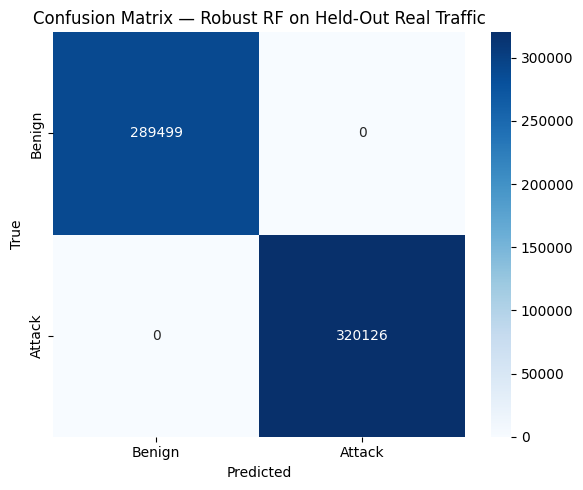

In [21]:
# Predict class labels on the hold-out real traffic
y_pred_test = rf_robust.predict(X_real_test)

# Predict class probabilities for ROC AUC and threshold tuning
y_prob_test = rf_robust.predict_proba(X_real_test)[:, 1]  # Take probability of class "1" (attack)

# Use the standard evaluation function to report metrics and confusion matrix
evaluate_attack(
    y_true   = y_real_test,
    y_pred   = y_pred_test,
    y_scores = y_prob_test,
    title    = "Robust RF on Held-Out Real Traffic"
)


Classification Report — Robust RF – White-box Attack (Held-Out)
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    289499
      Attack       1.00      1.00      1.00    320126

    accuracy                           1.00    609625
   macro avg       1.00      1.00      1.00    609625
weighted avg       1.00      1.00      1.00    609625

Accuracy:     1.0000
Precision:    1.0000
Recall:       1.0000
F1-Score:     1.0000
ROC AUC:      1.0000
Evasion Rate: 0.00% (0 of 320126 attacks)


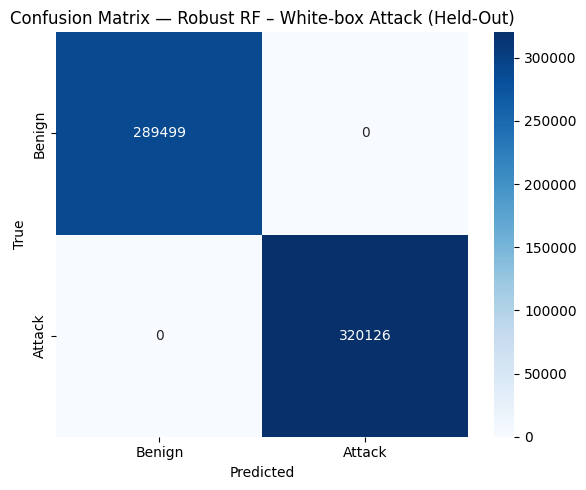


Classification Report — Robust RF – Grey-box Attack (Held-Out)
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    289499
      Attack       1.00      1.00      1.00     20000

    accuracy                           1.00    309499
   macro avg       1.00      1.00      1.00    309499
weighted avg       1.00      1.00      1.00    309499

Accuracy:     1.0000
Precision:    1.0000
Recall:       1.0000
F1-Score:     1.0000
ROC AUC:      1.0000
Evasion Rate: 0.00% (0 of 20000 attacks)


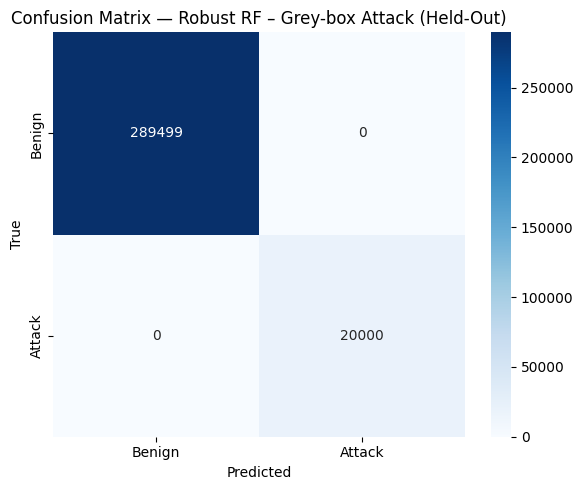


Classification Report — Robust RF – Black-box Attack (Held-Out)
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    289499
      Attack       1.00      1.00      1.00    320126

    accuracy                           1.00    609625
   macro avg       1.00      1.00      1.00    609625
weighted avg       1.00      1.00      1.00    609625

Accuracy:     1.0000
Precision:    1.0000
Recall:       1.0000
F1-Score:     1.0000
ROC AUC:      1.0000
Evasion Rate: 0.00% (2 of 320126 attacks)


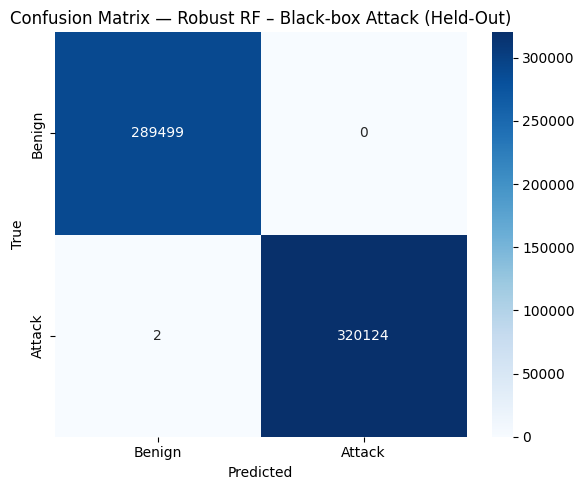

In [22]:
# Extract benign flows from the held-out test set
X_benign_test = X_real_test[y_real_test == 0]
y_benign_test = y_real_test[y_real_test == 0]

# Generate adversarial versions of the HELD-OUT ATTACKS
X_wb_test, y_wb_test = generate_whitebox_best(X_real_test, y_real_test)
X_gb_test, y_gb_test = generate_greybox_best(X_real_test, y_real_test)
X_bb_test, y_bb_test = generate_blackbox_best(X_real_test, y_real_test)

# Helper to evaluate robust model on mixed test set
def eval_attack_test(X_adv, y_adv, title):
    X_test_mix = pd.concat([X_benign_test, X_adv], ignore_index=True)
    y_test_mix = pd.concat([y_benign_test, y_adv], ignore_index=True)
    y_pred = rf_robust.predict(X_test_mix)
    y_prob = rf_robust.predict_proba(X_test_mix)[:, 1]
    evaluate_attack(y_test_mix, y_pred, y_prob, title=title)

# Run mixed evaluations
eval_attack_test(X_wb_test, y_wb_test, "Robust RF – White-box Attack (Held-Out)")
eval_attack_test(X_gb_test, y_gb_test, "Robust RF – Grey-box Attack (Held-Out)")
eval_attack_test(X_bb_test, y_bb_test, "Robust RF – Black-box Attack (Held-Out)")


## Black-box Attack – Decision-based Nearest-Benign Binary Search Blend

This decision-based, fully black-box attack only requires querying the model’s predicted class:

1. **Sample** \(N\)=200 held-out attack flows from real test traffic.  
2. **Sample** a subset of benign training flows (2,000) and find the **nearest** benign neighbor for each attack (Euclidean distance).  
3. For each attack–benign pair, perform a **binary search** on the blending ratio \(\alpha\in[0,1]\):
   - Compute \(\displaystyle x_\alpha = \alpha\,b + (1-\alpha)\,x\).  
   - Query `model.predict(x_α)`.  
   - If classified as benign (0), move \(\alpha\) upper; otherwise move \(\alpha\) lower.  
   - Repeat for 10 steps to find the **minimal** \(\alpha\) that achieves misclassification.  
4. **Collect** these blended adversarial samples and **evaluate** them mixed with held-out benign flows via `evaluate_attack()`.


Classification Report — Nearest-Benign Blend Attack on N=1000
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    289499
      Attack       0.00      0.00      0.00      1000

    accuracy                           1.00    290499
   macro avg       0.50      0.50      0.50    290499
weighted avg       0.99      1.00      0.99    290499

Accuracy:     0.9966
Precision:    0.0000
Recall:       0.0000
F1-Score:     0.0000
ROC AUC:      0.5460
Evasion Rate: 100.00% (1000 of 1000 attacks)


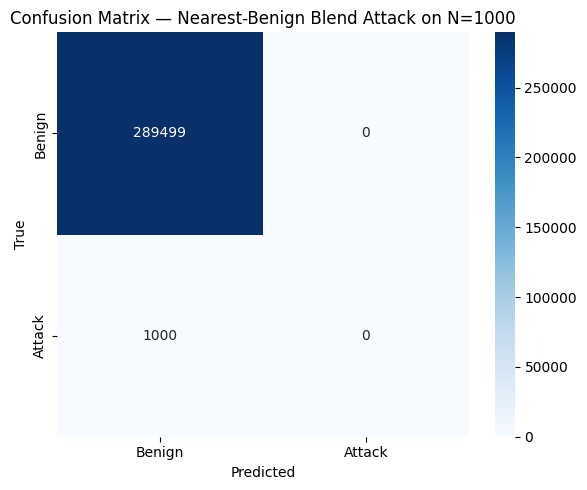

In [23]:
import numpy as np
import pandas as pd

# Parameters
N = min(1000, (y_real_test == 1).sum())   # up to 1000 attack samples
benign_pool_size = 5000
search_steps = 10

# Prepare held-out attack & benign sets
X_att_all = X_real_test[y_real_test == 1].reset_index(drop=True)
X_benign_train = X_real_train[y_real_train == 0]

# Sample N attack flows
X_att = X_att_all.sample(n=N, random_state=42).reset_index(drop=True)

# Sample a subset of benign training flows
benign_subset = X_benign_train.sample(
    n=min(benign_pool_size, len(X_benign_train)),
    random_state=42
).reset_index(drop=True)

# Find nearest benign neighbor for each attack
att_vals = X_att.values
ben_vals = benign_subset.values
dists = np.linalg.norm(att_vals[:, None, :] - ben_vals[None, :, :], axis=2)
nearest_idx = np.argmin(dists, axis=1)
B = ben_vals[nearest_idx]

# Binary-search blend per sample
adv = np.zeros_like(att_vals)
for i in range(N):
    x = att_vals[i]
    b = B[i]
    low, high = 0.0, 1.0
    for _ in range(search_steps):
        mid = (low + high) / 2
        x_mid = mid * b + (1-mid) * x
        df_mid = pd.DataFrame([x_mid], columns=X_att.columns)
        pred = rf_robust.predict(df_mid)[0]
        if pred == 0:  # misclassified as benign
            high = mid
        else:
            low = mid
    adv[i] = high * b + (1-high) * x

# Build mixed test set and evaluate
X_adv10 = pd.DataFrame(adv, columns=X_att.columns)
y_adv10 = pd.Series(1, index=X_adv10.index)

X_test_mix = pd.concat(
    [X_real_test[y_real_test == 0].reset_index(drop=True), X_adv10],
    ignore_index=True
)
y_test_mix = pd.concat(
    [y_real_test[y_real_test == 0].reset_index(drop=True), y_adv10],
    ignore_index=True
)

# Evaluate
y_pred = rf_robust.predict(X_test_mix)
y_prob = rf_robust.predict_proba(X_test_mix)[:, 1]
evaluate_attack(
    y_true   = y_test_mix,
    y_pred   = y_pred,
    y_scores = y_prob,
    title    = f"Nearest-Benign Blend Attack on N={N}"
)
